In [1]:
library(slingshot)
library(ArchR)
quiet_library <- function(...) {
    suppressPackageStartupMessages(library(...))
}
quiet_library('tidyverse')
quiet_library("hise")
quiet_library('ArchR')
quiet_library('data.table')
quiet_library('parallel')
quiet_library('dplyr')
library(anndata)
library(BSgenome.Hsapiens.UCSC.hg38)
options(future.globals.maxSize = 1000 * 1024^5)
Sys.setenv( TZ="Etc/GMT+1" )
addArchRGenome("hg38")
addArchRThreads(threads = 30)
library(SingleCellExperiment)
library(scater)
library(scran)
library(dplyr)
library(patchwork)
library(vroom)

pal <- c(RColorBrewer::brewer.pal(9, "Set1"), RColorBrewer::brewer.pal(8, "Set2"))
set.seed(123)


Loading required package: princurve

Warning message:
“package ‘princurve’ was built under R version 4.3.3”
Loading required package: TrajectoryUtils

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Warning message:
“package ‘MatrixGenerics’ was built under R version 4.3.3”
Loading required package: matrixStats

Warning message:
“package ‘matrixStats’ was built under R version 4.3.3”

Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, col

In [2]:
motif_df <- vroom('/home/workspace/IHA_Review_Analysis/Other_Analysis/06_TEAseq_Day0/motif_score_all_cell.csv',
                  num_threads=10)
motif_df<-as.data.frame(motif_df)

New names:
• `` -> `...1`
Rows: 288581 Columns: 890
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (6): ...1, Sample, barcodes, AIFI_L1, AIFI_L2, AIFI_L3
dbl (884): TSSEnrichment, ReadsInTSS, ReadsInPromoter, ReadsInBlacklist, Pro...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
scRNA_QC<-read.csv("scRNA_obs.csv")

In [4]:
barcode_matching<-read.csv("/home//workspace/IHA_Review_Analysis/Other_Analysis/06_TEAseq_Day0/barcodes_matching.csv")

In [5]:
barcode_matching<-barcode_matching %>% filter(barcodes_scRNA %in%scRNA_QC$X )

In [6]:
barcode_matching<-barcode_matching%>% filter( AIFI_L3 %in% c('Core naive CD4 T cell',
                                              'CM CD4 T cell',
                                              'GZMB- CD27+ EM CD4 T cell',
                                              'GZMB- CD27- EM CD4 T cell',
                                              'KLRF1- GZMB+ CD27- memory CD4 T cell'))

In [7]:
barcode_matching<-barcode_matching[!is.na(barcode_matching$barcodes_scATAC	),]

In [8]:
meta<-read.csv('/home//workspace/private/bri_figure_all_files_test/jupyter/BRI_Figures_Final_V2/Figure5/03_TEAseq_PenSenior/meta_data_GEO.csv')

In [9]:
meta$cohort<-substr(meta$subject_id.ch1,1,3)

In [10]:
table(meta$Batch,meta$cohort)

         
          BR2 UP1
  B065-P1   1   3
  B069-P1   1   3
  B076-P1   6   2

In [11]:
scRNA_QC$leiden<-as.character(scRNA_QC$leiden)

In [12]:
scRNA_QC<-left_join(scRNA_QC,barcode_matching,by=c("barcodes"="barcodes_scRNA"))

In [13]:
num_cells <- length(scRNA_QC$leiden)  # Number of cells
dummy_matrix <- matrix(0, nrow = 1, ncol = num_cells)

sce <- SingleCellExperiment(assays = list(counts = dummy_matrix))




In [14]:
colData(sce)$leiden <- scRNA_QC$leiden
colData(sce)$barcodes<-rownames(scRNA_QC)
reducedDims(sce) <- list(UMAP = as.matrix(scRNA_QC[c("UMAP_1","UMAP_2")]))

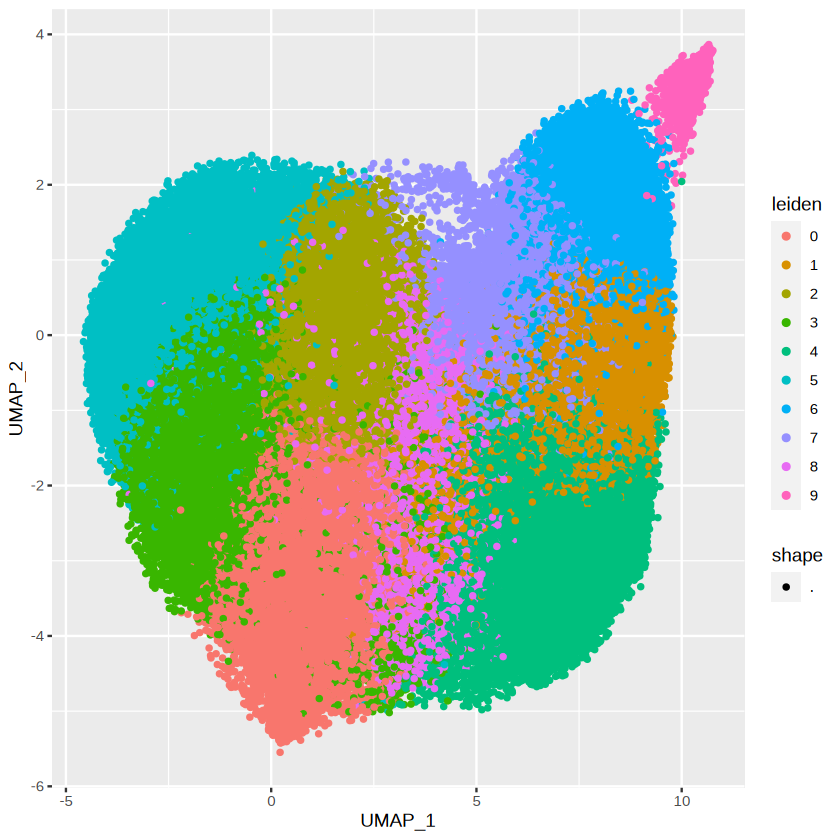

In [15]:
ggplot(scRNA_QC, aes(x=UMAP_1, y=UMAP_2)) + 
  geom_point(aes(color=leiden,shape="."))

In [16]:
sce <- slingshot(sce, 
                 clusterLabels = 'leiden',
                 approx_points=200,
                 extend='n',
                 start.clus= "5",
                 reducedDim = 'UMAP')
saveRDS(sce,"sce_processed.RDS")

In [17]:
sce<-readRDS("sce_processed.RDS")

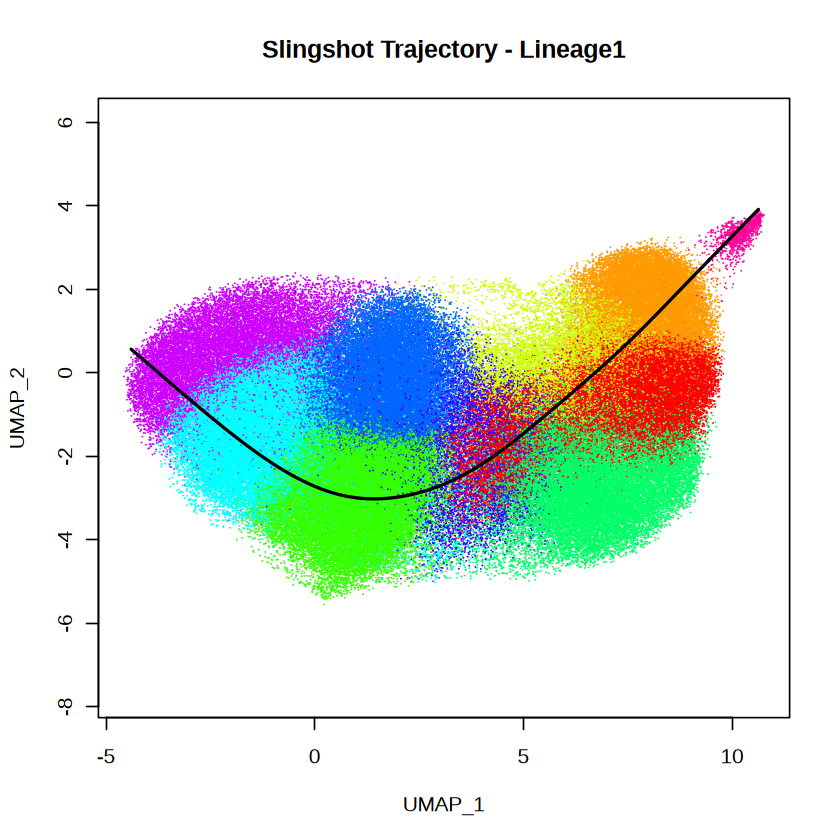

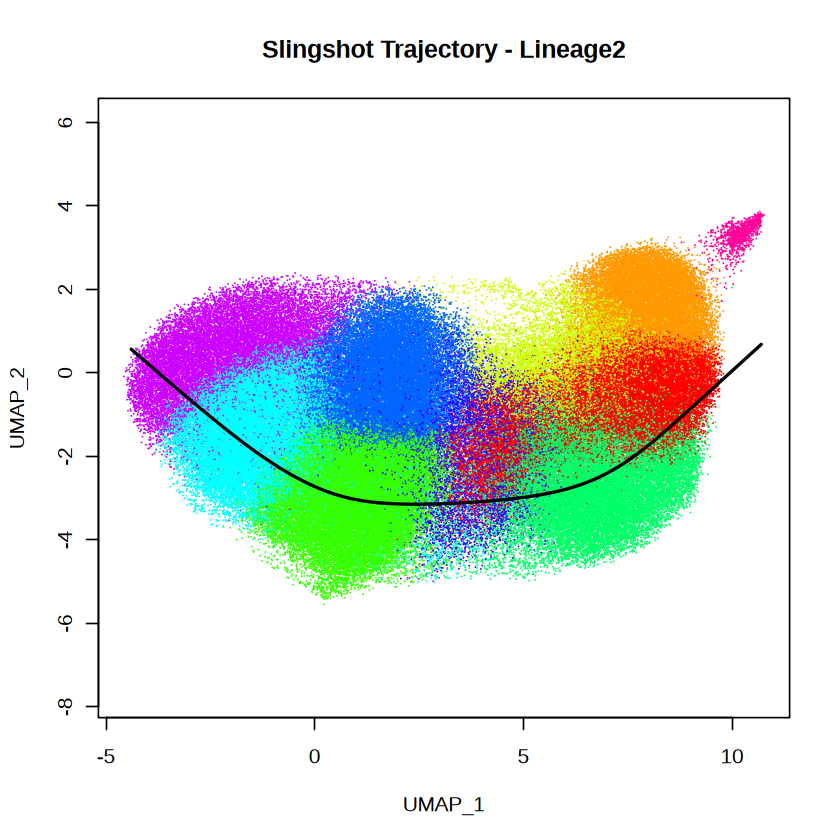

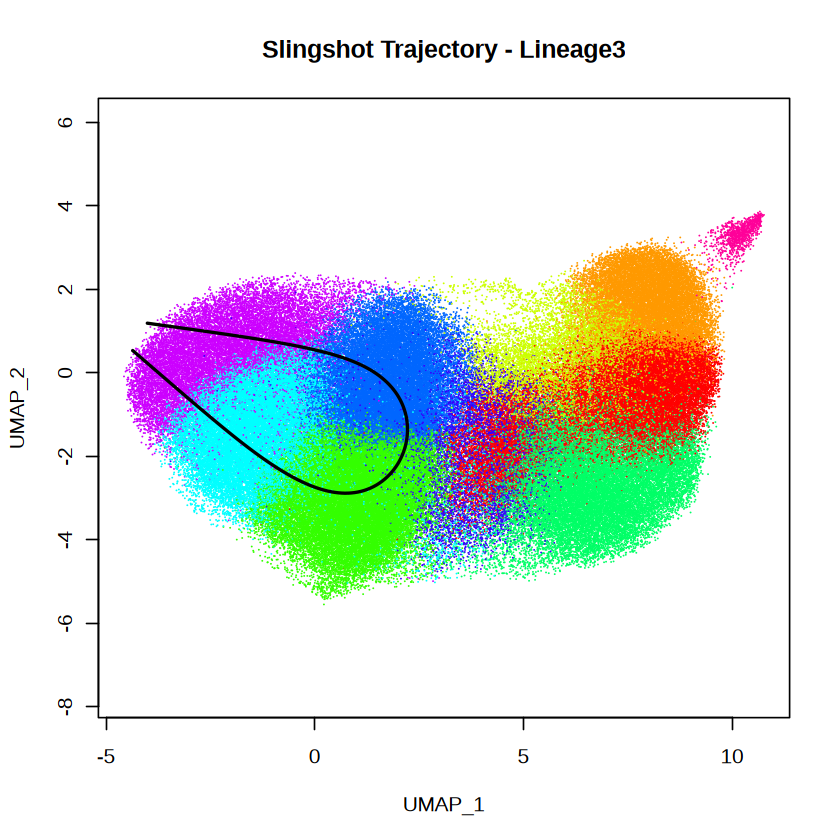

In [18]:
library(slingshot)

pal <- rainbow(length(unique(scRNA_QC$leiden)))
DD<-SlingshotDataSet(sce)
# Loop through Lineage 1 to 5
for (i in 1:5) {
  lineage_name <- paste0("Lineage", i)
  
  if (!lineage_name %in% names(DD@curves)) {
    next  
  }
  
  DD_subset <- DD
  DD_subset@curves <- list(DD@curves[[lineage_name]])

  plot(scRNA_QC[, c("UMAP_1", "UMAP_2")],
       col = pal[match(scRNA_QC$leiden, unique(scRNA_QC$leiden))], 
       pch = 16, asp = 1, cex = 0.1, 
       main = paste("Slingshot Trajectory -", lineage_name))

  lines(DD_subset, lwd = 2, col = 'black')
}

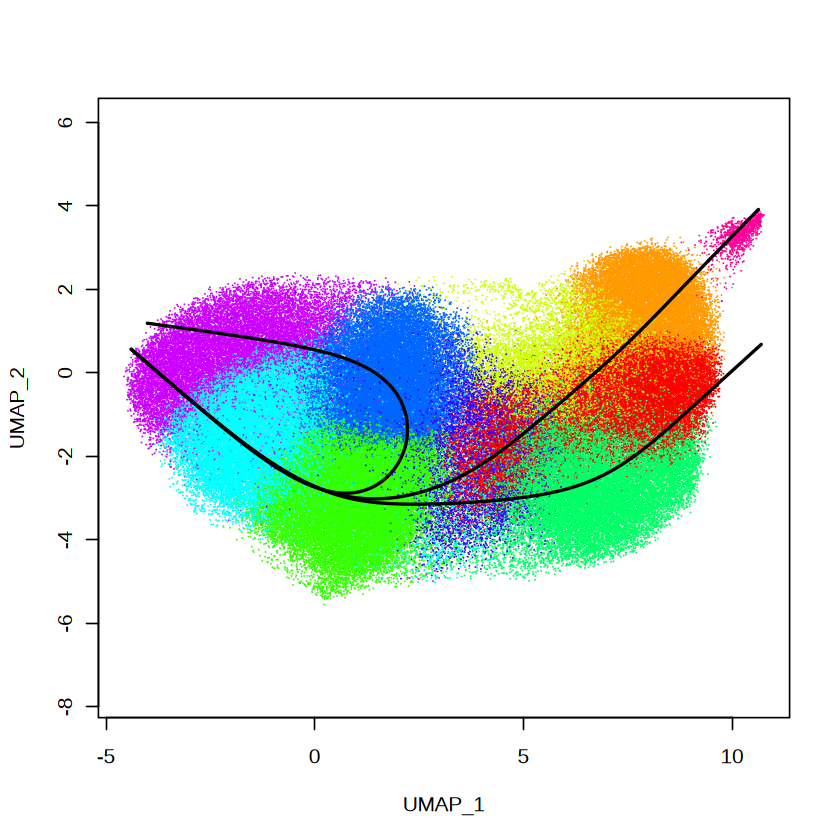

In [19]:
plot(scRNA_QC[c("UMAP_1", "UMAP_2")],
     col = pal[match(scRNA_QC$leiden, unique(scRNA_QC$leiden))], 
     pch = 16, asp = 1, cex = 0.1)
lines(SlingshotDataSet(sce), lwd=2,  col = 'black')

In [20]:
pseudotime <- slingPseudotime(sce, na = FALSE)


Warning message:
“package ‘viridis’ was built under R version 4.3.3”
Loading required package: viridisLite

Warning message:
“package ‘viridisLite’ was built under R version 4.3.3”


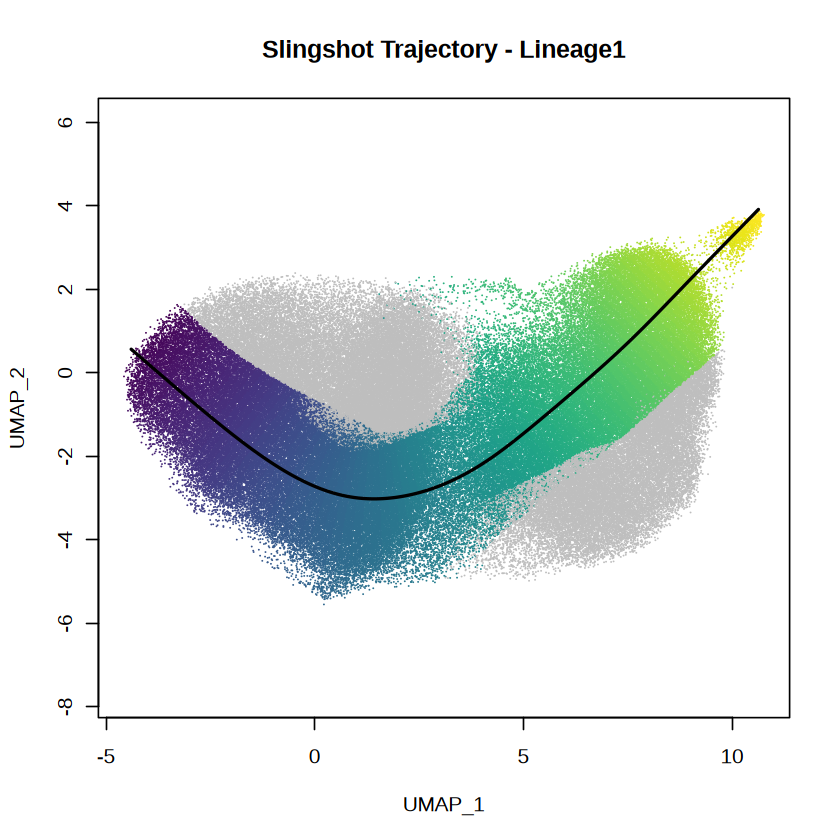

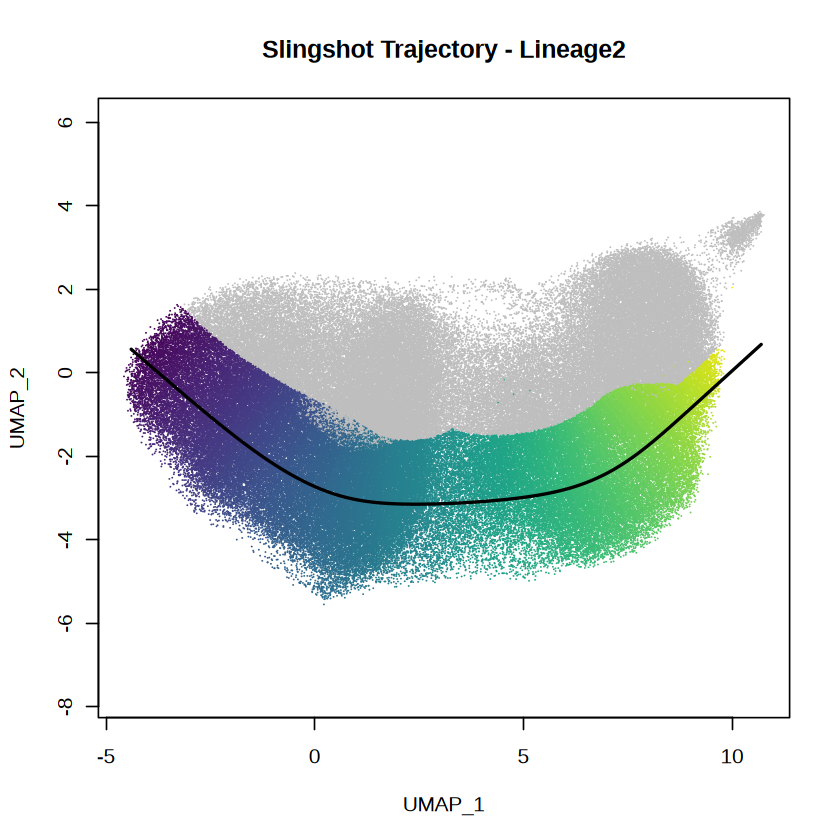

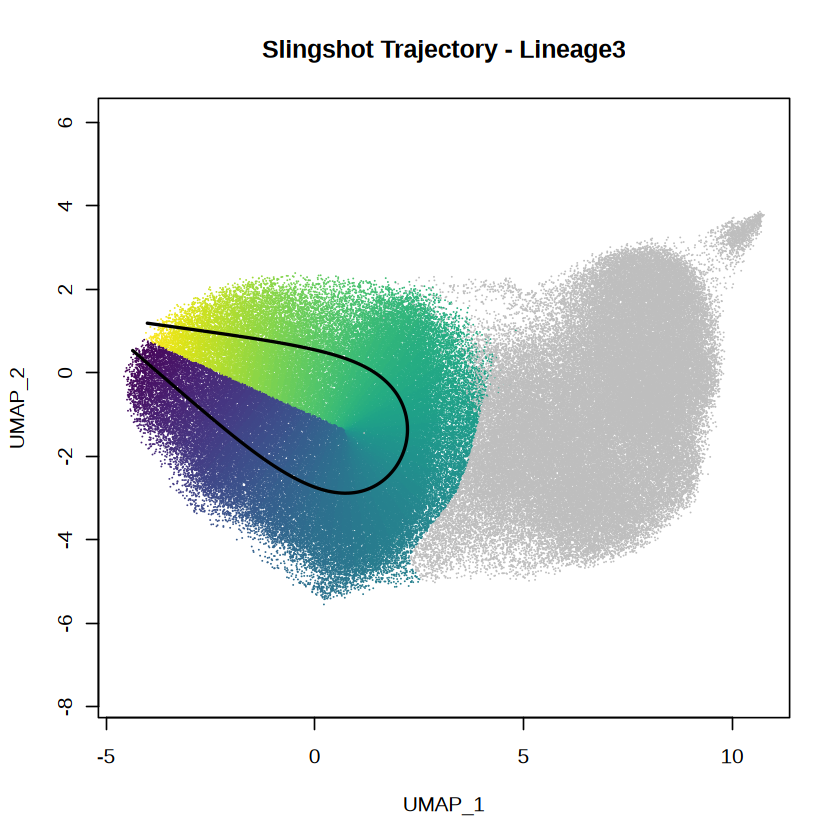

In [21]:
library(viridis) 

pal <- viridis(100)

DD <- SlingshotDataSet(sce)

for (i in 1:5) {
  lineage_name <- paste0("Lineage", i)
  
  if (!lineage_name %in% names(DD@curves)) {
    next  
  }
  
  pseudotime <- slingPseudotime(DD)[, lineage_name]
  
  in_lineage <- !is.na(pseudotime)
  
  col_by_pseudotime <- rep("grey", length(pseudotime))
  col_by_pseudotime[in_lineage] <- pal[cut(pseudotime[in_lineage], breaks = 100)]

  DD_subset <- DD
  DD_subset@curves <- list(DD@curves[[lineage_name]])

  plot(scRNA_QC[, c("UMAP_1", "UMAP_2")],
       col = col_by_pseudotime, 
       pch = 16, asp = 1, cex = 0.1, 
       main = paste("Slingshot Trajectory -", lineage_name))

  lines(DD_subset, lwd = 2, col = 'black')
}

In [22]:
DD<-SlingshotDataSet(sce)

In [23]:
DD@curves <- list(Lineage1 = DD@curves$Lineage1)

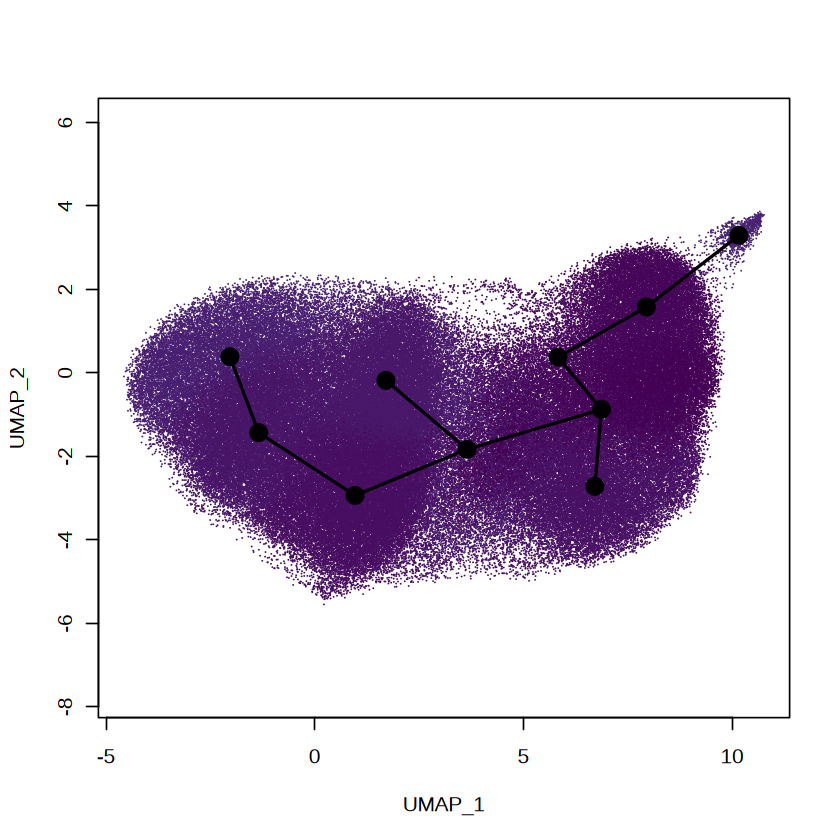

In [24]:
plot(scRNA_QC[c("UMAP_1", "UMAP_2")],
     col = pal[match(scRNA_QC$leiden, unique(scRNA_QC$leiden))], 
     pch = 16, asp = 1, cex = 0.1)
lines(SlingshotDataSet(sce), lwd=2, type = 'lineages', col = 'black')


In [25]:
SlingshotDataSet(sce)

class: SlingshotDataSet 

 Samples Dimensions
  173904          2

lineages: 3 
Lineage1: 5  3  0  8  1  7  6  9  
Lineage2: 5  3  0  8  1  4  
Lineage3: 5  3  0  8  2  

curves: 3 
Curve1: Length: 18.746	Samples: 104479.3
Curve2: Length: 17.495	Samples: 90600.09
Curve3: Length: 15.852	Samples: 93082.33

In [26]:
curve.assignments <- slingBranchID(sce)
table(curve.assignments)

curve.assignments
    1   1,2 1,2,3   1,3     2   2,3     3 
38930 12902 55369  2242 26006     9 38446 

In [27]:
pseudotime <- slingPseudotime(sce, na = FALSE)
cellWeights <- slingCurveWeights(sce)

x <- rowMeans(pseudotime)
x <- x / max(x)
o <- order(x)

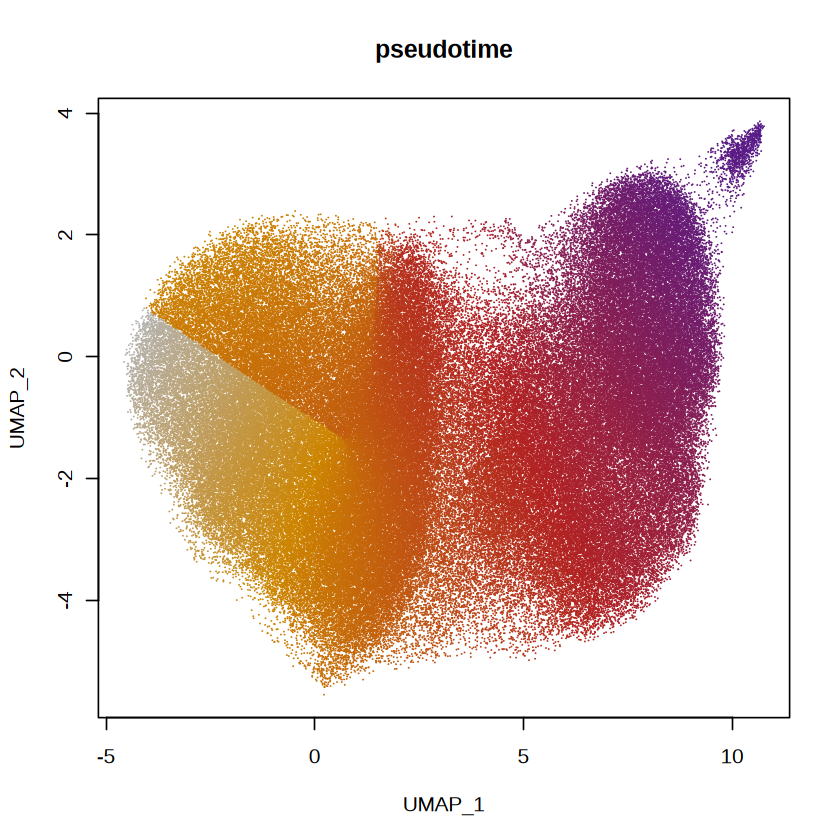

In [28]:
{
  plot(reducedDims(sce)$UMAP[o, ],
    main = paste0("pseudotime"), pch = 16, cex = 0.1, 
    col = colorRampPalette(c("grey70", "orange3", "firebrick", "purple4"))(199)[x[o] * 198 + 1]
  )
}

In [29]:
length(curve.assignments)

[1] 173904

In [30]:
pesudo_time_df<-as.data.frame(reducedDims(sce)$UMAP[o, ])
pesudo_time_df$pesudo_time<-x[o]
pesudo_time_df$pesudo_time_1<-as.data.frame(pseudotime)["Lineage1"][o,]
pesudo_time_df$pesudo_time_2<-as.data.frame(pseudotime)["Lineage2"][o,]
pesudo_time_df$pesudo_time_3<-as.data.frame(pseudotime)["Lineage3"][o,]

pesudo_time_df$curve.assignments<-curve.assignments[o]

#pesudo_time_df$celltype_new<-projHeme1_subset@cellColData$celltype_new[o]
pesudo_time_df <- cbind(pesudo_time_df, scRNA_QC[o, ])
pesudo_time_df$barcodes<-colData(sce)$barcodes[o]

In [31]:
motif_df<-left_join(motif_df,scRNA_QC, by=c("barcodes"='barcodes_scATAC'))

In [32]:
pesudo_time_df <- pesudo_time_df %>% select(-c(UMAP_1, UMAP_2))

In [33]:
pesudo_time_df<-left_join(pesudo_time_df,motif_df, by=c("barcodes_scATAC"='barcodes'))


In [34]:
pesudo_time_df <- pesudo_time_df %>% select(-ends_with(".y"))

colnames(pesudo_time_df) <- gsub("\\.x$", "", colnames(pesudo_time_df))

In [35]:
pesudo_time_df <- pesudo_time_df[, !duplicated(names(pesudo_time_df))]

In [36]:
pesudo_time_df <- pesudo_time_df %>%
  mutate('Age_Group' = case_when(
    startsWith(subject_id.ch1, "BR2") ~ "Older",
    TRUE ~ 'Childern' 
  ))


`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 7021 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 7021 rows containing missing values (`geom_point()`).”


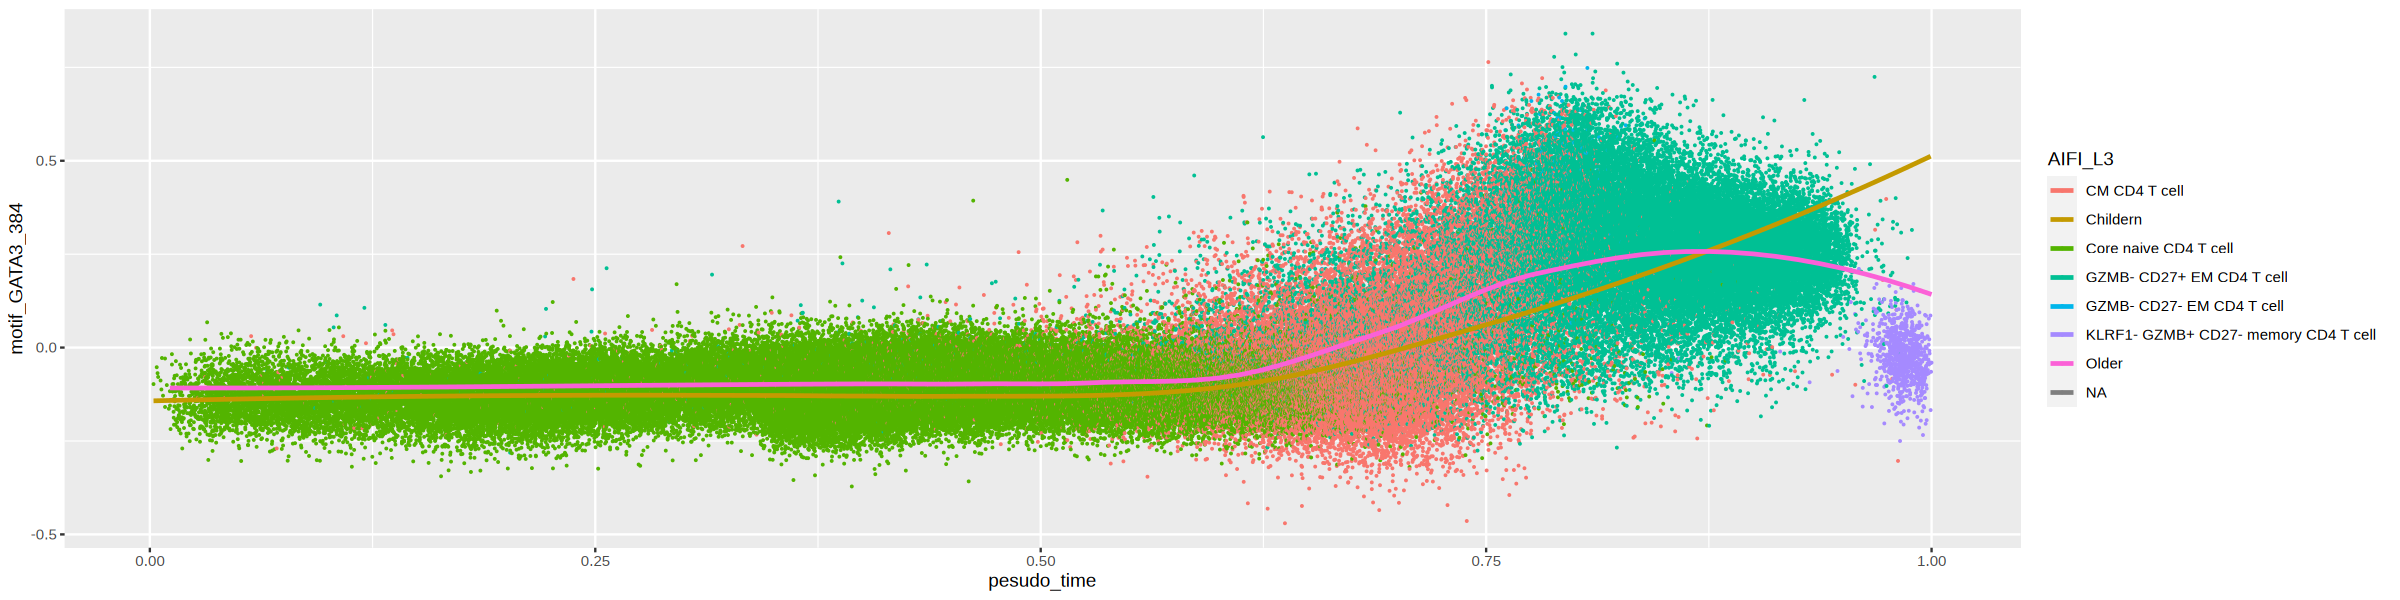

In [37]:
options(repr.plot.width = 20, repr.plot.height =5)

ggplot(pesudo_time_df , aes(pesudo_time,motif_GATA3_384,color=AIFI_L3)) +
geom_point(size=0.05)+ geom_smooth(method = loess,aes(group=Age_Group,color=Age_Group),se=FALSE)

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 3468 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 3468 rows containing missing values (`geom_point()`).”


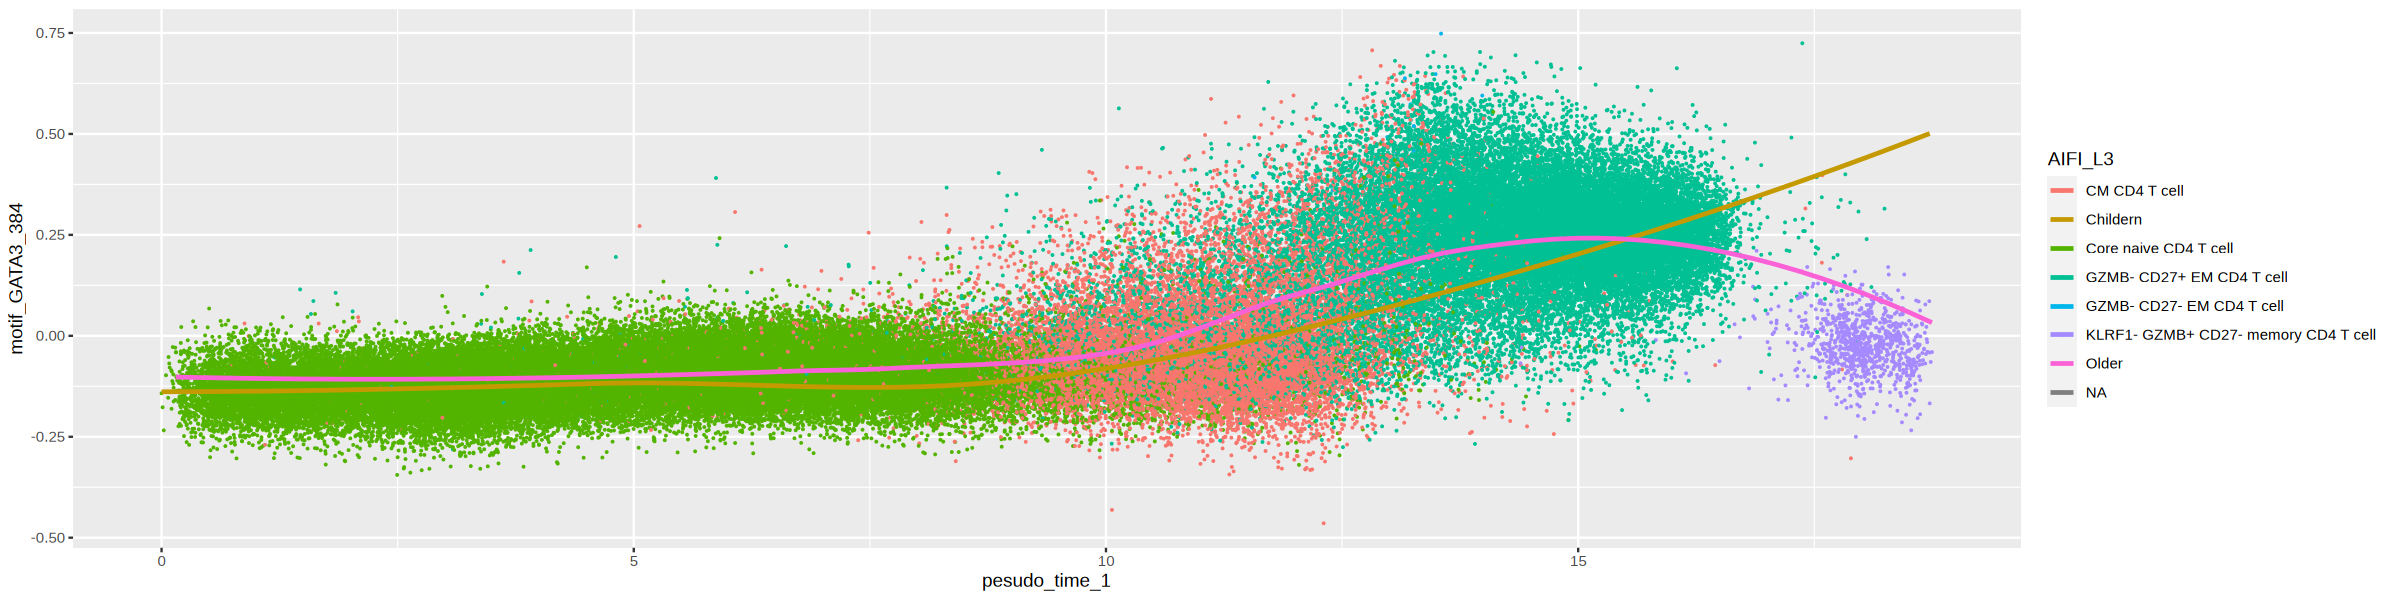

In [38]:
options(repr.plot.width = 20, repr.plot.height =5)


ggplot(pesudo_time_df  %>% filter(grepl("1",curve.assignments)) , 
       aes(pesudo_time_1,motif_GATA3_384,color=AIFI_L3)) +geom_point(size=0.05)+ 
geom_smooth(method = loess,aes(group=Age_Group,color=Age_Group),se=FALSE)

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 3787 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 3787 rows containing missing values (`geom_point()`).”


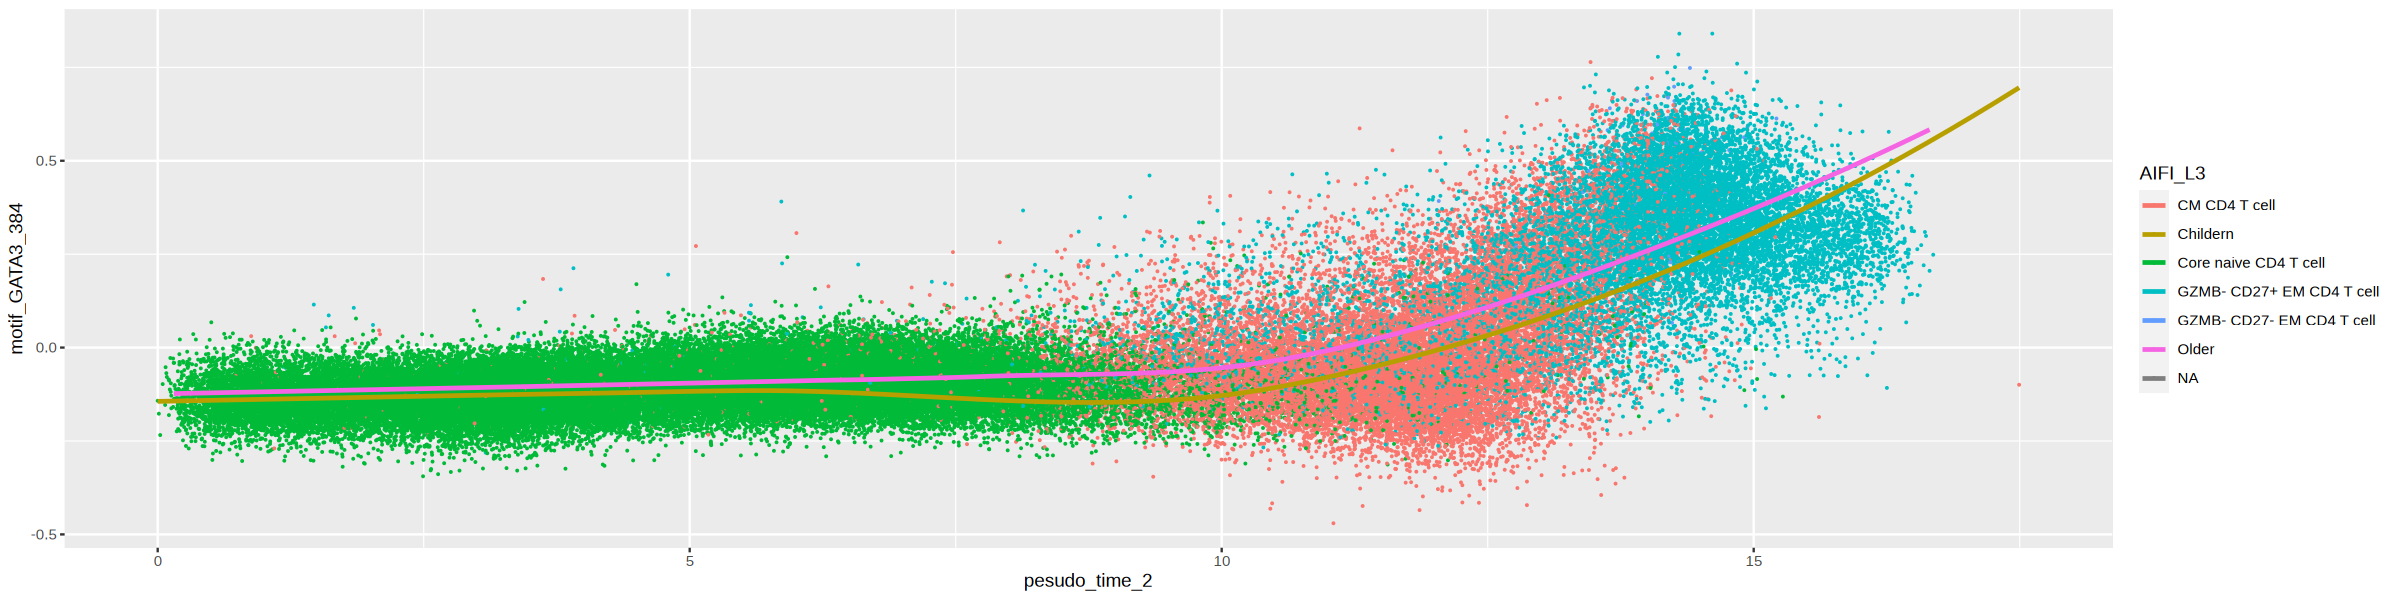

In [39]:
options(repr.plot.width = 20, repr.plot.height =5)


ggplot(pesudo_time_df  %>% filter(grepl("2",curve.assignments)) , 
       aes(pesudo_time_2,motif_GATA3_384,color=AIFI_L3)) +geom_point(size=0.05)+ 
geom_smooth(method = loess,aes(group=Age_Group,color=Age_Group),se=FALSE)

In [43]:
arrow::write_parquet(pesudo_time_df,"pesudo_time_df.parquet")